# Explore the Nav2D environment

In [1]:
import mujoco as mj
import gymnasium as gym
import nav2d
import pyautogui

width = 1920
height = 1080
default_camera_config = {"azimuth" : 90, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}

# Reference for setting visual flags https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#mjtvisflag
visual_options = {2: True, 8: True}      # e.g., visualize the joints by setting mjVIS_JOINT (index 2) = True

# There are a few visualization things that cannot be set when making the env
# Ref - https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/mujoco/mujoco_rendering.py
# They can only be changed via keypresses in the gymnasium mujoco rendering. 
# Here are some flags to specify what key to press. The key presses are simulated using `pyautogui`
# (Super rough appproach but oh well)
DEFAULT_CAMERA = "overhead_camera"
ENABLE_FRAME = True                     # enable the body frames
RENDER_EVERY_FRAME = True              # similar sim speed as MuJoCo rendering when set to False, else slower

env = gym.make("Nav2D-v0", 
               render_mode="human", 
               width=width, height=height,
               default_camera_config=default_camera_config,
               visual_options=visual_options
               )
obs, info = env.reset()

# Simulate keypress for visualization elements in gymnasium MuJoCo rendering
if DEFAULT_CAMERA=="overhead_camera": pyautogui.press('tab')
if ENABLE_FRAME: pyautogui.press('e') 
if not RENDER_EVERY_FRAME: pyautogui.press('d') 

for i in range(1):
    done = False
    # enable the body frame by simulating a keypress once lmao
    
    while not done:
        action = [1.0, 0, 1.0]
        nobs, rew, term, trunc, info = env.step(action)
        
        done = term or trunc
        obs = nobs if not done else env.reset()[0]
        # if done: print(nobs, info)

env.close()

: 

# Custom TD3 Training

In [1]:
# --- import the custom-made TD3 algorithm
import gymnasium as gym
import nav2d        # Have to import the nav2d Python script, else we can't make env
import numpy as np
import os, re
import sys
sys.path.insert(0,'..')
from algorithms import TD3

In [ ]:
model_registry = {
    'TD3_v0': {
        'actor_config': [256, 256],
        'critic_config': [256, 256]
    },
}

MODEL_NAME = 'TD3_v0'
ALPHA1 = 1e-3
ALPHA2 = 1e-3
BETA = 1e-3
GAMMA = 0.99
TAU_C = 5e-3
TAU_A = 5e-3
SIGMA = 0.2
CLIP = 0.5

BUFFER_SIZE = 10_000
BUFFER_INIT = 1_000
BATCH_SIZE = 512
  
UPDATE_FREQ = 2
UPDATE_STEP = 2
TRAIN_ITER = 100_000
TRAIN_CRIT = {"pass_limit": 3, "pass_score": 200, 'coeff_var_limit': 1.0}
RESULT_FOLDER = 'Nav2D_TD3_results'
CUDA_ENABLED = True
EARLY_STOP = True

run_00010:  17%|███████▏                                   | 16686/100000 [01:24<3:30:41,  6.59it/s]

Good training at episode   18 with reward of 265.705. Evaluation results μ=265.699, σ= 0.007, CV= 0.000


run_00010:  21%|████████▉                                  | 20912/100000 [01:48<1:57:55, 11.18it/s]

Good training at episode   20 with reward of 265.703. Evaluation results μ=265.651, σ= 0.034, CV= 0.000


run_00010:  21%|█████████▎                                  | 21306/100000 [01:57<07:14, 181.12it/s]

Good training at episode   21 with reward of 265.601. Evaluation results μ=265.649, σ= 0.035, CV= 0.000
Training done early at episode    21. Best model saved at episode    18 with evaluate reward (265.699, 0.007)
Best model episode 18


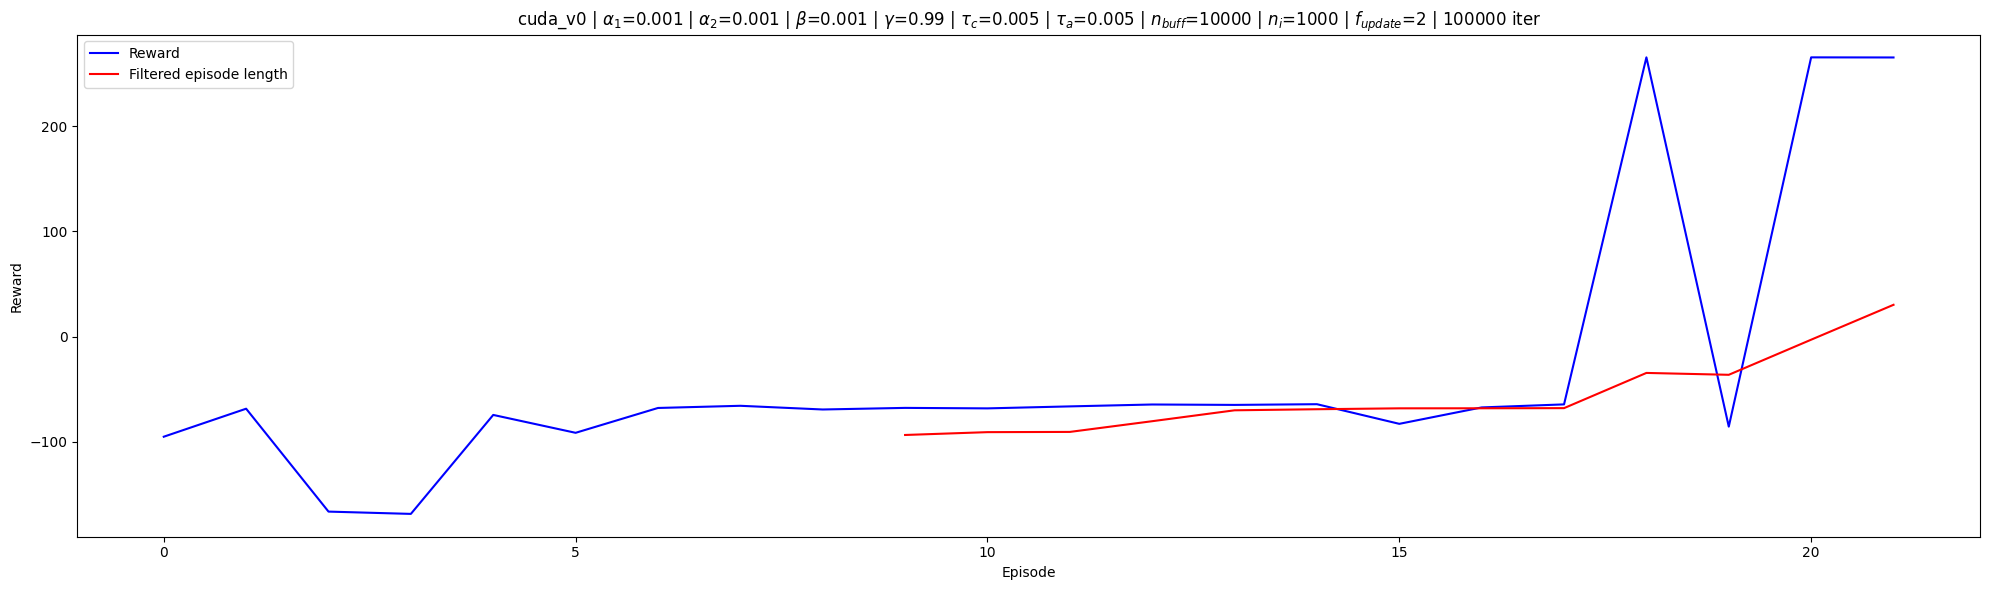

In [3]:
env = gym.make("Nav2D-v0", render_mode="human")

for i in range(1):    
    seed = np.random.randint(1,100)
    TD3_experiment = TD3(model_name = MODEL_NAME, model_registry=model_registry, env=env,
                     alpha1=ALPHA1,alpha2=ALPHA2,beta=BETA,gamma=GAMMA,
                     tau_c=TAU_C,tau_a=TAU_A,sigma=SIGMA,clip=CLIP,
                     buffer_size=BUFFER_SIZE,buffer_init=BUFFER_INIT, batch_size=BATCH_SIZE, 
                     update_f=UPDATE_FREQ, update_step=UPDATE_STEP, iter=TRAIN_ITER,
                     seed=seed,
                     train_crit=TRAIN_CRIT,
                     result_folder=RESULT_FOLDER,
                     cuda_enabled=CUDA_ENABLED)                 
    TD3_experiment.train(early_stop=EARLY_STOP,verbose=True)         

# SB3 Training

In [ ]:
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
import nav2d        # Have to import the nav2d Python script, else we can't make env
import os, re

In [ ]:
env = make_vec_env("Nav2D-v0", n_envs=8, vec_env_cls=DummyVecEnv)
model = TD3("MlpPolicy", env, 
            learning_rate=5e-3,        # lr for all networds - Q-values, Actor, Value function
            buffer_size=10_000,      # replay buffer size
            learning_starts=1_000,        # # of data collection step before training
            batch_size=1_000,
            tau=5e-3,                  # polyak update coefficient
            gamma=0.99,
            train_freq=1,
            gradient_steps=4, 
            action_noise=None, 
            n_steps=1,                  # n-step TD learning
            policy_delay=2,             # the policy and target networks are updated every policy_delay steps
            target_policy_noise=0.05,   # stdev of noise added to target policy
            target_noise_clip=0.1,      # limit of asbsolute value of noise
            verbose=2)
model.learn(total_timesteps=100_000)

# Save the Trained Model

In [ ]:
BASE_DIR = os.getcwd()
RESULT_FOLDER = 'Nav2D_TD3_SB3_results'
RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.exists(os.path.join(RESULT_DIR,d))]
run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
# model.save('reacher')

trial_number = max(run_numbers, default=-1) + 1
model.save(f'{RESULT_FOLDER}/run_{trial_number:05d}')

# Load and Simulate the Model

In [ ]:
import pyautogui

model_load = TD3.load('Nav2D_TD3_SB3_results/run_00005')

width = 1920
height = 1080
default_camera_config = {"azimuth" : 90.0, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}
camera_id = 2

DEFAULT_CAMERA = "overhead_camera"
ENABLE_FRAME = True                     # enable the body frames
RENDER_EVERY_FRAME = True              # similar sim speed as MuJoCo rendering when set to False, else slower

test_env = gym.make("Nav2D-v0", render_mode='human', 
                    width=width,height=height,
                    default_camera_config=default_camera_config,
                    camera_id=camera_id,
                    # frame_skip=2,
                    # camera_name="camera",
                    # max_episode_steps=100
                    )
obs, info = test_env.reset()

if DEFAULT_CAMERA=="overhead_camera": pyautogui.press('tab')
if ENABLE_FRAME: pyautogui.press('e') 
if not RENDER_EVERY_FRAME: pyautogui.press('d') 

for eps in range(5):
    obs, _ = test_env.reset()
    dones = False

    while not dones:
        action, _ = model_load.predict(obs, deterministic=True)
        nobs, rewards, dones, info, _ = test_env.step(action)
        obs = nobs if not dones else test_env.reset()
        # vec_env.render("human")

test_env.close()